# Gauging Sentiment of Emerging Technology on Twitter

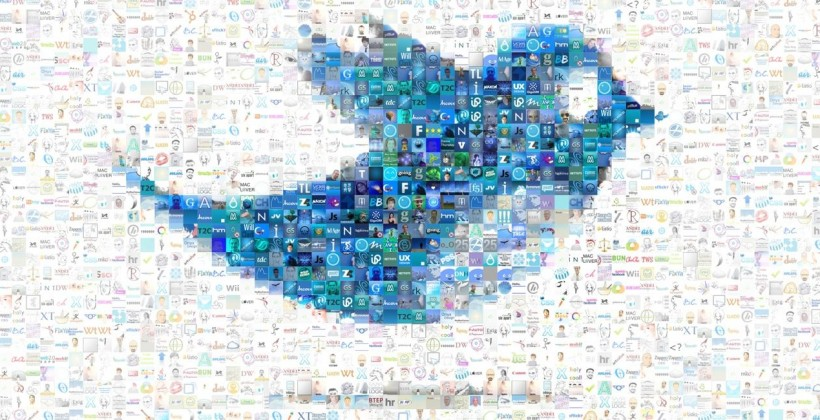

## Business Problem

Gauging sentiment of a market sector, company, or product is very helpful to investment analysis. An invetment firm is analyszing emerging technology and would like a predictive model that can analyze text data to classify the sentiment; poitive or negative. Being able to gauge overall sentiment will help in analysis of the sector and help them strategically place investments in the market.

## Data Understanding

The dataset consists of thousands of tweets from the SXSW festival pertaining to Apple and Google products. The tweets are labeled as positive, negative, no opinion, or "I can't tell." We will analyze the data from a binary classification standpoint and only keep the positive and negative classes.

The data is heavily imbalanced with positive tweets outnumbering the negative by a 6:1 ratio.

## Methods

Using NLP methods we will pre-process the data to get it ready for modeling.
> 1. First, we will clean the data by removing stop words, punctuation and other pieces of text that do not add value to the analysis such as numbers, and twitter slang.
> 2. Then we will tokenize he text with regular expressions
> 3. Next we will both stem and lemmatize the text separatley so that we can train models on both and see which is better.
> 4. Finally we will vectorize the text with both TF-IDF and Count vectorization so that we again can see which will provide a better model.
> 5. We will also look at removing mutually exclusive words from our training set to see if it imporoves our model.

We will split our dataset into training and testing data, and to handle the imbalance we with use SMOTE to provide a balanced training set. 

Once the data is ready for modeling we will build a baseline and then train several models with differing parameters, score them with cross validation, and generate predictions from our models to compare with the test set and attain our final results.

In [1]:
# Import our dependencies
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import SMOTE
import string
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from collections import Counter
from imblearn.under_sampling import NearMiss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# EDA

In [2]:
# Read in our dataset and view the first 5 rows
df = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# View our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [4]:
# See the various products and companies the tweets are about
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
# Get a feel for the class labels
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

### Data Cleaning

In [6]:
# Since we are analyzing sentiment we will drop the labels with no sentiment
pos_neg = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
pos_neg = pos_neg[pos_neg['is_there_an_emotion_directed_at_a_brand_or_product'] != "No emotion toward brand or product"]

>Extremely unbalanced dataset

In [7]:
pos_neg.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)

Positive emotion    0.840363
Negative emotion    0.159637
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [8]:
# Drop the products/companies column since we will not be using this in our text analysis
# Change column names to something short and easier to work with
pos_neg = pos_neg.drop('emotion_in_tweet_is_directed_at', axis=1)
pos_neg = pos_neg.rename(columns={'tweet_text':'text', 'is_there_an_emotion_directed_at_a_brand_or_product':'target'})
pos_neg.head()

,text,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [9]:
# Create a function to remove Twitter lingo like @'s and #'s and map it on our text column
def remove_ats_and_hashtags(text):
    entity_prefixes = ['@','#','�']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

pos_neg['text'] = pos_neg['text'].map(remove_ats_and_hashtags)

In [10]:
# Encode our classes/targets for modeling
pos_neg.replace({'Negative emotion' : 0, 'Positive emotion' : 1}, inplace=True)

In [11]:
# Tansform our text to all lower case letters
pos_neg['text'] = pos_neg['text'].str.lower()
pos_neg.head()

,text,target
0,i have a 3g iphone after 3 hrs tweeting at aus...,0
1,know about awesome ipad iphone app that you ll...,1
2,can not wait for 2 also they should sale them ...,1
3,i hope this year s festival isn t as crashy as...,0
4,great stuff on fri marissa mayer google tim o ...,1


### Explore the words

In [12]:
# Tokenize our text to split into words
pos_neg['text_tokenized'] = pos_neg['text'].apply(word_tokenize)

In [13]:
# Create a function that will view the 20 most frequently used words
def visualize_top_20(freq_dist, title):

    # Extract data for plotting
    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)

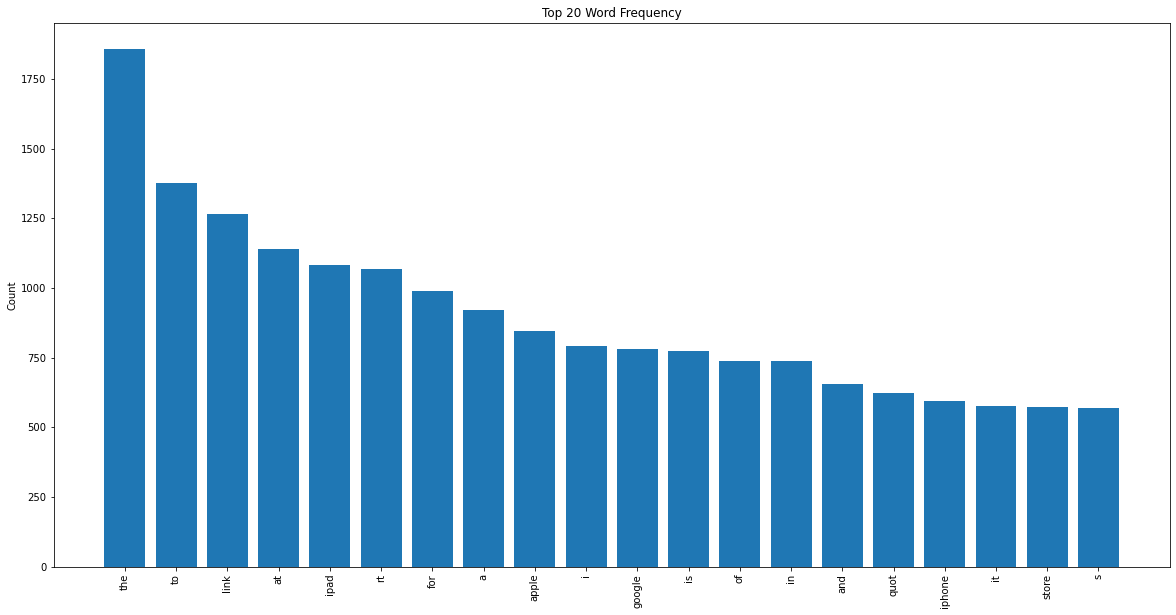

In [14]:
# create a frequency distribution and view it as a histogram
pos_neg_freq_dist = FreqDist(pos_neg['text_tokenized'].explode())

visualize_top_20(pos_neg_freq_dist, "Top 20 Word Frequency")

There are a number of stopwords, 1 character and other phrases that won't add value to our model.

### Remove stopwords, punctuation and other unwanted phrases



In [15]:
# Create a stopwrods list for removal, add punctuation and other phrases to drop
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
new_stops = ('quot', 'rt', 'i', 'amp')
stopwords_list += list(new_stops)

In [16]:
# Create a function that will remove the stopwords list from the text and apply it to our text
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are in stopwords_list have been removed
    """
    stops_rmv_list = [token for token in token_list if token not in stopwords_list]
    return stops_rmv_list

pos_neg['stopwords_removed'] = pos_neg['text_tokenized'].apply(remove_stopwords)

In [17]:
# Remove numbers and single letters and create a text column for modeling with regular expressions
pattern = "([a-z]{4,})"
regex_tokenizer = RegexpTokenizer(pattern)

pos_neg['regex_text'] = [' '.join(text) for text in pos_neg.stopwords_removed]
pos_neg['regex_text_tokenized'] = [regex_tokenizer.tokenize(text) for text in pos_neg['regex_text']]
pos_neg['regex_text'] = [' '.join(text) for text in pos_neg.regex_text_tokenized]

In [18]:
pos_neg.head()

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",iphone tweeting austin dead need upgrade plugi...,"[iphone, tweeting, austin, dead, need, upgrade..."
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone likely appreciate des...,"[know, awesome, ipad, iphone, likely, apprecia..."
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait also sale,"[wait, also, sale]"
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone,"[hope, year, festival, crashy, year, iphone]"
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff marissa mayer google reilly tech b...,"[great, stuff, marissa, mayer, google, reilly,..."


### Stem words

In [19]:
snow_stemmer = SnowballStemmer(language="english")

pos_neg['stemmed_text'] = [snow_stemmer.stem(text) for text in pos_neg['regex_text']]

pos_neg.head()

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized,stemmed_text
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",iphone tweeting austin dead need upgrade plugi...,"[iphone, tweeting, austin, dead, need, upgrade...",iphone tweeting austin dead need upgrade plugi...
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone likely appreciate des...,"[know, awesome, ipad, iphone, likely, apprecia...",know awesome ipad iphone likely appreciate des...
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait also sale,"[wait, also, sale]",wait also sal
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone,"[hope, year, festival, crashy, year, iphone]",hope year festival crashy year iphon
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff marissa mayer google reilly tech b...,"[great, stuff, marissa, mayer, google, reilly,...",great stuff marissa mayer google reilly tech b...


### Lemmatize words

In [20]:
lemmer = WordNetLemmatizer()

pos_neg['lemmed_text'] = [lemmer.lemmatize(text) for text in pos_neg['regex_text']]

pos_neg.head(10)

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized,stemmed_text,lemmed_text
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",iphone tweeting austin dead need upgrade plugi...,"[iphone, tweeting, austin, dead, need, upgrade...",iphone tweeting austin dead need upgrade plugi...,iphone tweeting austin dead need upgrade plugi...
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone likely appreciate des...,"[know, awesome, ipad, iphone, likely, apprecia...",know awesome ipad iphone likely appreciate des...,know awesome ipad iphone likely appreciate des...
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait also sale,"[wait, also, sale]",wait also sal,wait also sale
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone,"[hope, year, festival, crashy, year, iphone]",hope year festival crashy year iphon,hope year festival crashy year iphone
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff marissa mayer google reilly tech b...,"[great, stuff, marissa, mayer, google, reilly,...",great stuff marissa mayer google reilly tech b...,great stuff marissa mayer google reilly tech b...
7,is just starting is around the corner and is o...,1,"[is, just, starting, is, around, the, corner, ...","[starting, around, corner, hop, skip, jump, go...",starting around corner skip jump good time,"[starting, around, corner, skip, jump, good, t...",starting around corner skip jump good tim,starting around corner skip jump good time
8,beautifully smart and simple idea rt wrote abo...,1,"[beautifully, smart, and, simple, idea, rt, wr...","[beautifully, smart, simple, idea, wrote, ipad...",beautifully smart simple idea wrote ipad http ...,"[beautifully, smart, simple, idea, wrote, ipad...",beautifully smart simple idea wrote ipad http ...,beautifully smart simple idea wrote ipad http ...
9,counting down the days to plus strong canadian...,1,"[counting, down, the, days, to, plus, strong, ...","[counting, days, plus, strong, canadian, dolla...",counting days plus strong canadian dollar mean...,"[counting, days, plus, strong, canadian, dolla...",counting days plus strong canadian dollar mean...,counting days plus strong canadian dollar mean...
10,excited to meet the at so i can show them my s...,1,"[excited, to, meet, the, at, so, i, can, show,...","[excited, meet, show, sprint, galaxy, still, r...",excited meet show sprint galaxy still running ...,"[excited, meet, show, sprint, galaxy, still, r...",excited meet show sprint galaxy still running ...,excited meet show sprint galaxy still running ...
11,find amp start impromptu parties at with http ...,1,"[find, amp, start, impromptu, parties, at, wit...","[find, start, impromptu, parties, http, bit, l...",find start impromptu parties http gvlrin wait ...,"[find, start, impromptu, parties, http, gvlrin...",find start impromptu parties http gvlrin wait ...,find start impromptu parties http gvlrin wait ...


### You can see in several of the tweets that stemming removes the 'e' from words like 'sale' and 'iphone' so we will use the lemmatized words for modeling

## View the new frequency distribution of words after processing

In [21]:
pos_neg['lemmed_text_tokenized'] = pos_neg['lemmed_text'].apply(word_tokenize)

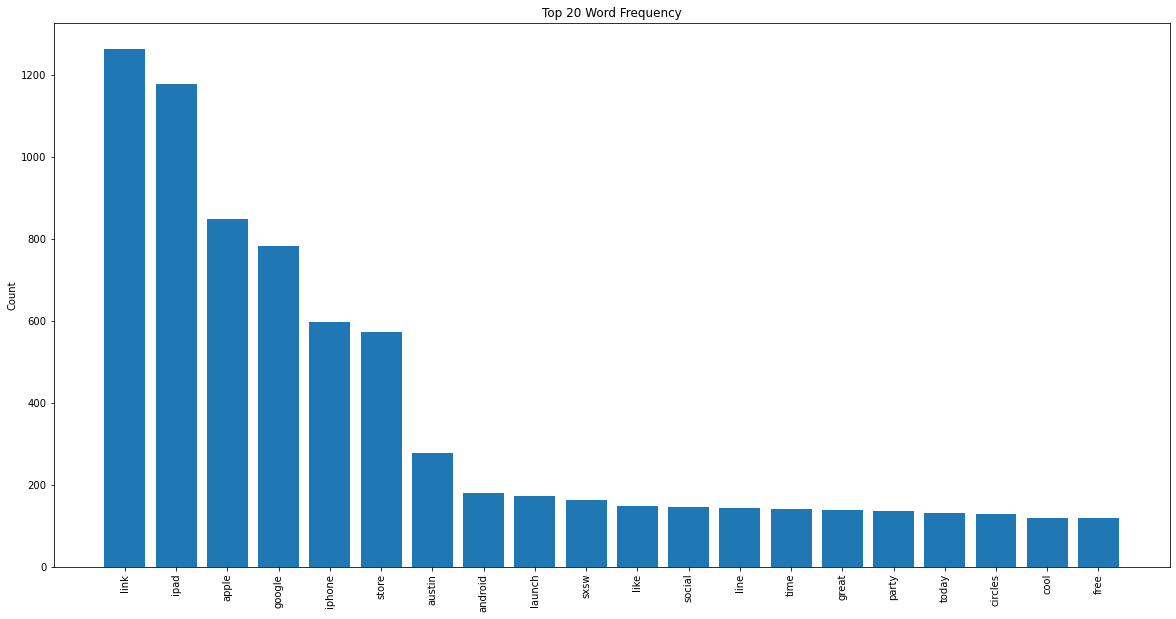

In [22]:
# create a frequency distribution and view it as a histogram
lemmed_text_freq_dist = FreqDist(pos_neg['lemmed_text_tokenized'].explode())

visualize_top_20(lemmed_text_freq_dist, "Top 20 Word Frequency")

### Train Test Split

In [23]:
X = pos_neg.drop(['target'], axis=1)
y = pos_neg['target']

X_train , X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=30)

In [24]:
y_train.value_counts(normalize=True)

1    0.844746
0    0.155254
Name: target, dtype: float64

### Build and score a baseline model

#### Using Count Vectorization on lemmatized text

In [25]:
# Use count vectorization
count = CountVectorizer()
X_count_vectorized = count.fit_transform(X_train['lemmed_text'])

In [26]:
# With such an imbalanced dataset use SMOTE to balance training data
smote_count = SMOTE(k_neighbors=3)
X_train_resampled, y_train_resampled = smote_count.fit_resample(
    X_count_vectorized, y_train)

In [27]:
# Check that the training set is balanced now
y_train_resampled.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

In [28]:
# Instantiate a MultinomialNB classifier and fi it to training data
baseline_model = MultinomialNB()

baseline_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
baseline_cv = cross_val_score(baseline_model, X_train_resampled, y_train_resampled)
print("Baseline:", baseline_cv.mean())

Baseline: 0.7984498346662656


In [29]:
# Use count vectorization with bigrams
count_bigram = CountVectorizer(ngram_range=(1,2))
X_count_vectorized_bigrams = count_bigram.fit_transform(X_train['lemmed_text'])

In [30]:
smote_count = SMOTE(k_neighbors=3)
X_train_resampled_bigram, y_train_resampled_bigram = smote_count.fit_resample(
    X_count_vectorized_bigrams, y_train)

In [31]:
baseline_model_bigram = MultinomialNB()

baseline_model_bigram.fit(X_train_resampled_bigram, y_train_resampled_bigram)

baseline_bigram_cv = cross_val_score(baseline_model_bigram, X_train_resampled_bigram, y_train_resampled_bigram)
print("Baseline            :", baseline_cv.mean())
print("Baseline w/ bigrams :", baseline_bigram_cv.mean())

Baseline            : 0.7984498346662656
Baseline w/ bigrams : 0.7410189822398432


#### Score using TF-IDF Vectorization

In [32]:
tfidf = TfidfVectorizer(max_features=20)
X_train_vectorized_tfidf = tfidf.fit_transform(X_train['lemmed_text'])

In [33]:
smote_count = SMOTE(k_neighbors=3)
X_train_resampled_tfidf, y_train_resampled_tfidf = smote_count.fit_resample(
    X_train_vectorized_tfidf, y_train)

In [34]:
baseline_model_tfidf = MultinomialNB()

baseline_model_tfidf.fit(X_train_resampled_tfidf, y_train_resampled_tfidf)

baseline_tfidf_cv = cross_val_score(baseline_model_tfidf, X_train_resampled_tfidf, y_train_resampled_tfidf)
print("Baseline            :", baseline_cv.mean())
print("Baseline w/ bigrams :", baseline_bigram_cv.mean())
print("Baseline TF-IDF     :", baseline_tfidf_cv.mean())

Baseline            : 0.7984498346662656
Baseline w/ bigrams : 0.7410189822398432
Baseline TF-IDF     : 0.6482504236162848


#### Looks like the regular baseline model scored the best - "Multinomial Naive Bayes"

> Lets see how it does on test data

              precision    recall  f1-score   support

           0       0.53      0.64      0.58       121
           1       0.92      0.88      0.90       562

    accuracy                           0.84       683
   macro avg       0.72      0.76      0.74       683
weighted avg       0.85      0.84      0.84       683



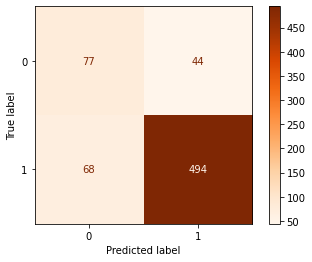

In [126]:
X_test_vectorized = count.transform(X_test['lemmed_text'])
baseline_preds = baseline_model.predict(X_test_vectorized)

print(classification_report(y_test, baseline_preds))

plot_confusion_matrix(baseline_model, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

#### This scores well 
Overall Accuracy of 84%
> Predicts positive sentiment with an accuracy of 89%     
> Predicts negative sentiment with an accuracy of 61%

#### And the bigrams model too

              precision    recall  f1-score   support

           0       0.61      0.55      0.58       121
           1       0.91      0.93      0.92       562

    accuracy                           0.86       683
   macro avg       0.76      0.74      0.75       683
weighted avg       0.85      0.86      0.86       683



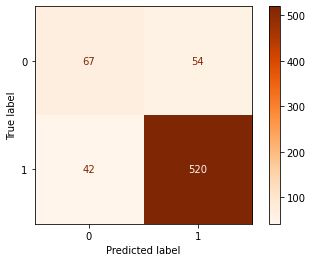

In [36]:
X_test_vectorized_bigrams = count_bigram.transform(X_test['lemmed_text'])
baseline_preds = baseline_model_bigram.predict(X_test_vectorized_bigrams)

bigram_preds = baseline_model_bigram.predict(X_test_vectorized_bigrams)

print(classification_report(y_test, bigram_preds))

plot_confusion_matrix(baseline_model_bigram, X_test_vectorized_bigrams, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

#### Bigrams also score well 
Overall Accuracy of 86%
> Predicts positive sentiment with an accuracy of 93%     
> Predicts negative sentiment with an accuracy of 55%

#### Lets run the model on the original text with no processing and see how it does

In [37]:
count_og_text = CountVectorizer()
X_count_og_text_vectorized = count_og_text.fit_transform(X_train['text'])

In [38]:
smote_og_count = SMOTE(k_neighbors=3)
X_train_resampled_og, y_train_resampled_og = smote_og_count.fit_resample(
    X_count_og_text_vectorized, y_train)

In [39]:
baseline_model_og = MultinomialNB()

baseline_model_og.fit(X_train_resampled_og, y_train_resampled_og)

# Evaluate the model
baseline_og_cv = cross_val_score(baseline_model_og, X_train_resampled_og, y_train_resampled_og)
print("Baseline            :", baseline_cv.mean())
print("Baseline w/ og text :", baseline_og_cv.mean())

Baseline            : 0.7984498346662656
Baseline w/ og text : 0.8084166269097984


              precision    recall  f1-score   support

           0       0.52      0.48      0.50       121
           1       0.89      0.90      0.90       562

    accuracy                           0.83       683
   macro avg       0.70      0.69      0.70       683
weighted avg       0.82      0.83      0.83       683



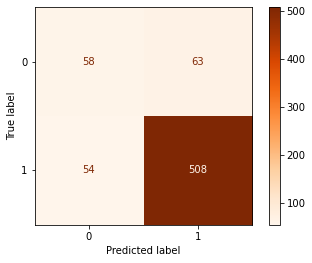

In [40]:
X_test_og_vectorized = count_og_text.transform(X_test['text'])
baseline_og_preds = baseline_model_og.predict(X_test_og_vectorized)

print(classification_report(y_test, baseline_og_preds))

plot_confusion_matrix(baseline_model_og, X_test_og_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

#### Surprisingly it scores almost as well as the model with lemmatized text
Overall Accuracy of 83%
> Predicts positive sentiment with an accuracy of 91%     
> Predicts negative sentiment with an accuracy of 50%

#### We will stick with the Lemmatized text model

### Let's run a few more models to see if we can score better
We will stick with these parameters:
> Lemmatized text       
> Count vectorization

In [41]:
# K Nearest Neighbors with n=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train_resampled, y_train_resampled)

knn_5_cv = cross_val_score(knn_5, X_train_resampled, y_train_resampled)
print("Baseline :", baseline_cv.mean())
print("KNN_5    :", knn_5_cv.mean())

Baseline : 0.7984498346662656
KNN_5    : 0.5795423299013167


              precision    recall  f1-score   support

           0       0.21      0.98      0.34       121
           1       0.98      0.18      0.31       562

    accuracy                           0.33       683
   macro avg       0.59      0.58      0.32       683
weighted avg       0.84      0.33      0.31       683



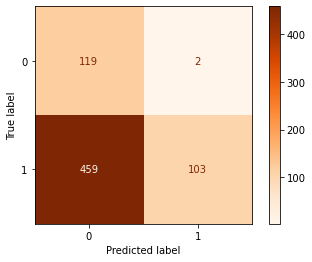

In [42]:
knn_5_preds = knn_5.predict(X_test_vectorized)

print(classification_report(y_test, knn_5_preds))

plot_confusion_matrix(knn_5, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [43]:
# K Nearest Neighbors with n=3
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train_resampled, y_train_resampled)

knn_3_cv = cross_val_score(knn_3, X_train_resampled, y_train_resampled)
print("Baseline :", baseline_cv.mean())
print("KNN_5    :", knn_5_cv.mean())
print("KNN_3    :", knn_3_cv.mean())

Baseline : 0.7984498346662656
KNN_5    : 0.5795423299013167
KNN_3    : 0.6883425028730702


              precision    recall  f1-score   support

           0       0.25      0.88      0.39       121
           1       0.94      0.43      0.59       562

    accuracy                           0.51       683
   macro avg       0.60      0.66      0.49       683
weighted avg       0.82      0.51      0.55       683



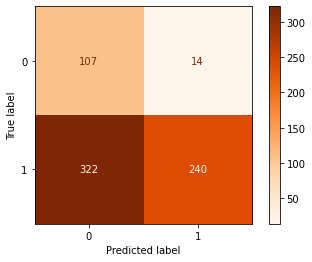

In [44]:
knn_3_preds = knn_3.predict(X_test_vectorized)

print(classification_report(y_test, knn_3_preds))

plot_confusion_matrix(knn_3, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [45]:
# Decision Tree (default)
tree = DecisionTreeClassifier()
tree.fit(X_train_resampled, y_train_resampled)

tree_cv = cross_val_score(tree, X_train_resampled, y_train_resampled)
print("Baseline :", baseline_cv.mean())
print("KNN_5    :", knn_5_cv.mean())
print("KNN_3    :", knn_3_cv.mean())
print("Tree     :", tree_cv.mean())

Baseline : 0.7984498346662656
KNN_5    : 0.5795423299013167
KNN_3    : 0.6883425028730702
Tree     : 0.8511119780589091


              precision    recall  f1-score   support

           0       0.36      0.55      0.43       121
           1       0.89      0.78      0.83       562

    accuracy                           0.74       683
   macro avg       0.62      0.67      0.63       683
weighted avg       0.80      0.74      0.76       683



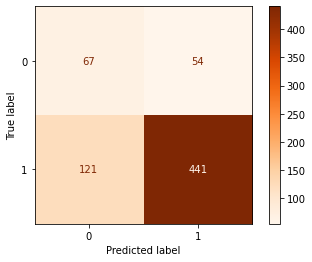

In [46]:
tree_preds = tree.predict(X_test_vectorized)

print(classification_report(y_test, tree_preds))

plot_confusion_matrix(tree, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [47]:
# Random Forest (default)
forest = RandomForestClassifier()
forest.fit(X_train_resampled, y_train_resampled)

forest_cv = cross_val_score(forest, X_train_resampled, y_train_resampled)
print("Baseline :", baseline_cv.mean())
print("KNN_5    :", knn_5_cv.mean())
print("KNN_3    :", knn_3_cv.mean())
print("Tree     :", tree_cv.mean())
print("Forest   :", forest_cv.mean())

Baseline : 0.7984498346662656
KNN_5    : 0.5795423299013167
KNN_3    : 0.6883425028730702
Tree     : 0.8511119780589091
Forest   : 0.8636827472426752


              precision    recall  f1-score   support

           0       0.40      0.55      0.46       121
           1       0.89      0.83      0.86       562

    accuracy                           0.78       683
   macro avg       0.65      0.69      0.66       683
weighted avg       0.81      0.78      0.79       683



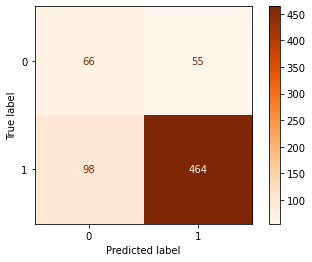

In [48]:
forest_preds = forest.predict(X_test_vectorized)

print(classification_report(y_test, forest_preds))

plot_confusion_matrix(forest, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [49]:
# Random Forest w/ bootstrap=False
forest_boot = RandomForestClassifier(bootstrap=False)
forest_boot.fit(X_train_resampled, y_train_resampled)

forest_boot_cv = cross_val_score(forest_boot, X_train_resampled, y_train_resampled)
print("Baseline    :", baseline_cv.mean())
print("KNN_5       :", knn_5_cv.mean())
print("KNN_3       :", knn_3_cv.mean())
print("Tree        :", tree_cv.mean())
print("Forest      :", forest_cv.mean())
print("Forest Boot :", forest_boot_cv.mean())

Baseline    : 0.7984498346662656
KNN_5       : 0.5795423299013167
KNN_3       : 0.6883425028730702
Tree        : 0.8511119780589091
Forest      : 0.8636827472426752
Forest Boot : 0.8771211953852264


              precision    recall  f1-score   support

           0       0.45      0.52      0.48       121
           1       0.89      0.86      0.88       562

    accuracy                           0.80       683
   macro avg       0.67      0.69      0.68       683
weighted avg       0.81      0.80      0.81       683



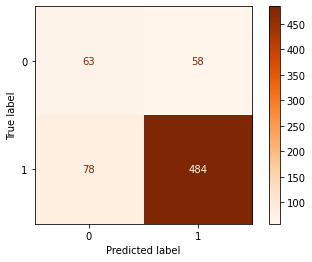

In [50]:
forest_boot_preds = forest_boot.predict(X_test_vectorized)

print(classification_report(y_test, forest_boot_preds))

plot_confusion_matrix(forest_boot, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [51]:
# Support Vector Machine (default)
clf = SVC()
clf.fit(X_train_resampled, y_train_resampled)

clf_cv = cross_val_score(clf, X_train_resampled, y_train_resampled)
print("Baseline    :", baseline_cv.mean())
print("KNN_5       :", knn_5_cv.mean())
print("KNN_3       :", knn_3_cv.mean())
print("Tree        :", tree_cv.mean())
print("Forest      :", forest_cv.mean())
print("Forest Boot :", forest_boot_cv.mean())
print("SVM         :", clf_cv.mean())

Baseline    : 0.7984498346662656
KNN_5       : 0.5795423299013167
KNN_3       : 0.6883425028730702
Tree        : 0.8511119780589091
Forest      : 0.8636827472426752
Forest Boot : 0.8771211953852264
SVM         : 0.9001012918827834


              precision    recall  f1-score   support

           0       0.39      0.26      0.32       121
           1       0.85      0.91      0.88       562

    accuracy                           0.80       683
   macro avg       0.62      0.59      0.60       683
weighted avg       0.77      0.80      0.78       683



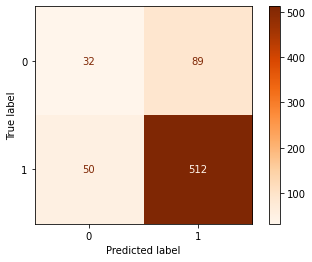

In [52]:
clf_preds = clf.predict(X_test_vectorized)

print(classification_report(y_test, clf_preds))

plot_confusion_matrix(clf, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

### Out of curiousity, let's see how the Decision Tree, The Random Forrests, and the SVM score with the original text

              precision    recall  f1-score   support

           0       0.38      0.48      0.42       121
           1       0.88      0.83      0.86       562

    accuracy                           0.77       683
   macro avg       0.63      0.66      0.64       683
weighted avg       0.79      0.77      0.78       683



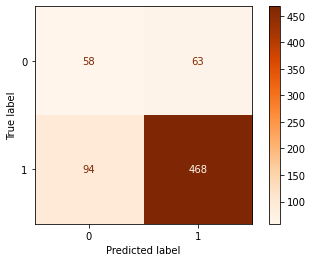

In [53]:
tree_og = DecisionTreeClassifier()
tree_og.fit(X_train_resampled_og, y_train_resampled_og)

tree_og_preds = tree_og.predict(X_test_og_vectorized)

print(classification_report(y_test, tree_og_preds))

plot_confusion_matrix(tree_og, X_test_og_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

           0       0.36      0.39      0.37       121
           1       0.87      0.85      0.86       562

    accuracy                           0.77       683
   macro avg       0.61      0.62      0.62       683
weighted avg       0.78      0.77      0.77       683



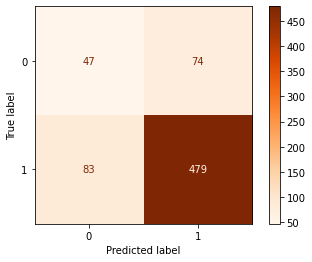

In [54]:
forest_og = RandomForestClassifier()
forest_og.fit(X_train_resampled_og, y_train_resampled_og)

forest_og_preds = forest_og.predict(X_test_og_vectorized)

print(classification_report(y_test, forest_og_preds))

plot_confusion_matrix(forest_og, X_test_og_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

           0       0.39      0.36      0.38       121
           1       0.87      0.88      0.87       562

    accuracy                           0.79       683
   macro avg       0.63      0.62      0.62       683
weighted avg       0.78      0.79      0.78       683



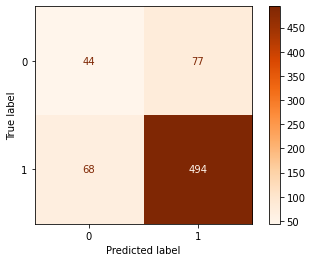

In [55]:
forest_boot_og = RandomForestClassifier(bootstrap=False)
forest_boot_og.fit(X_train_resampled_og, y_train_resampled_og)

forest_boot_og_preds = forest_boot_og.predict(X_test_og_vectorized)

print(classification_report(y_test, forest_boot_og_preds))

plot_confusion_matrix(forest_boot_og, X_test_og_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

           0       0.43      0.25      0.31       121
           1       0.85      0.93      0.89       562

    accuracy                           0.81       683
   macro avg       0.64      0.59      0.60       683
weighted avg       0.78      0.81      0.79       683



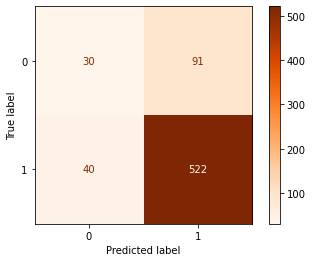

In [56]:
clf_og = SVC()
clf_og.fit(X_train_resampled_og, y_train_resampled_og)

clf_og_preds = clf_og.predict(X_test_og_vectorized)

print(classification_report(y_test, clf_og_preds))

plot_confusion_matrix(clf_og, X_test_og_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

### None of these models are as accurate as our Multinomial Naive Bayes models (baseline or bigrams) with lemmatized text

## Let's do an experiment with mutually exclusive text

> #### We will remove mutually exclusive text from our training data and see how it affects our models.

### Let's do some more EDA and processing for this new data

In [57]:
# Rejoin our training data sets
pos_neg_train = X_train.join(y_train)

In [58]:
pos_neg_train.target.value_counts()

1    2307
0     424
Name: target, dtype: int64

In [59]:
# Split the data set into positive and negative for analaysis
positive = pos_neg_train.loc[pos_neg['target'] == 1]
negative = pos_neg_train.loc[pos_neg['target'] == 0]

In [60]:
positive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2307 entries, 1435 to 4378
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   text                   2307 non-null   object
 1   text_tokenized         2307 non-null   object
 2   stopwords_removed      2307 non-null   object
 3   regex_text             2307 non-null   object
 4   regex_text_tokenized   2307 non-null   object
 5   stemmed_text           2307 non-null   object
 6   lemmed_text            2307 non-null   object
 7   lemmed_text_tokenized  2307 non-null   object
 8   target                 2307 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 180.2+ KB


In [61]:
negative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 2997 to 2252
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   text                   424 non-null    object
 1   text_tokenized         424 non-null    object
 2   stopwords_removed      424 non-null    object
 3   regex_text             424 non-null    object
 4   regex_text_tokenized   424 non-null    object
 5   stemmed_text           424 non-null    object
 6   lemmed_text            424 non-null    object
 7   lemmed_text_tokenized  424 non-null    object
 8   target                 424 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 33.1+ KB


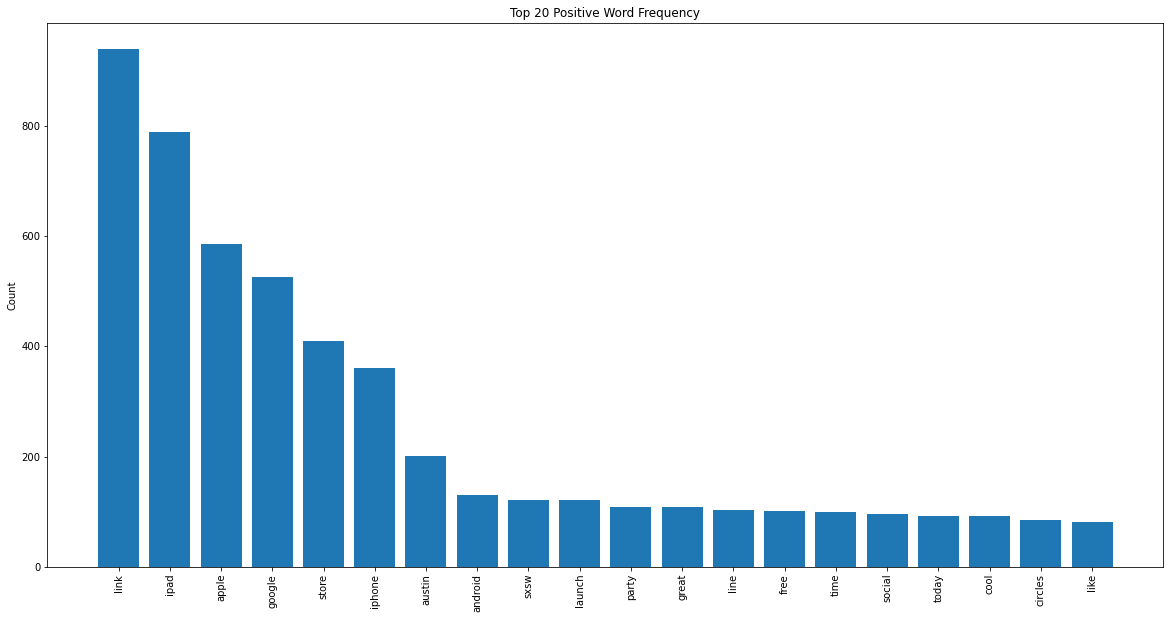

In [62]:
# View the 20 most frequently used words in the positive class
positive_freq_dist = FreqDist(positive['lemmed_text_tokenized'].explode())

visualize_top_20(positive_freq_dist, "Top 20 Positive Word Frequency")

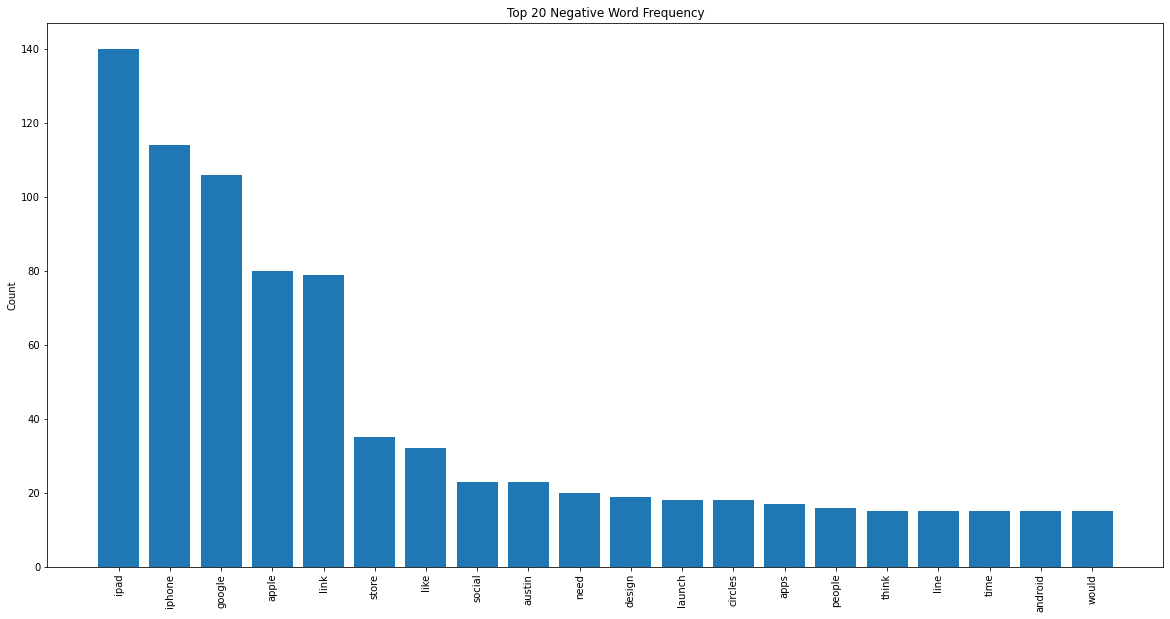

In [63]:
# View the 20 most frequently used words in the negative class
negative_freq_dist = FreqDist(negative['lemmed_text_tokenized'].explode())

visualize_top_20(negative_freq_dist, "Top 20 Negative Word Frequency")

### This is not very telling, and many words are the same, so lets see how removing mutual words affects this

In [75]:
# Create a 'Bag of Words' for the positive class
BoW_pos = [word for sentence in positive['lemmed_text_tokenized'] for word in sentence]

In [76]:
BoW_pos

['wise',
 'apple',
 'opening',
 'temp',
 'store',
 'austin',
 'link',
 'apparently',
 'tell',
 'bizzy',
 'android',
 'remedied',
 'marissa',
 'mayer',
 'connect',
 'digital',
 'physical',
 'worlds',
 'mobile',
 'link',
 'soundtrckr',
 'featured',
 'must',
 'link',
 'kick',
 'giving',
 'away',
 'ipad',
 'visit',
 'page',
 'enter',
 'link',
 'rumor',
 'apple',
 'opening',
 'temporary',
 'store',
 'downtown',
 'austin',
 'launch',
 'link',
 'another',
 'super',
 'smart',
 'move',
 'apple',
 'link',
 'temporary',
 'store',
 'sxsw',
 'dear',
 'please',
 'tell',
 'soon',
 'google',
 'circles',
 'unveiled',
 'thanks',
 'apple',
 'customer',
 'service',
 'notch',
 'even',
 'guys',
 'hanging',
 'line',
 'giving',
 'inventory',
 'updates',
 'nice',
 'pretty',
 'content',
 'pretty',
 'article',
 'ipad',
 'cooler',
 'twitter',
 'list',
 'current',
 'arctic',
 'explorers',
 'apple',
 'congress',
 'nice',
 'apple',
 'open',
 'popup',
 'shop',
 'core',
 'sxsw',
 'action',
 'link',
 'gets',
 'tattooed

In [77]:
# Create a 'Bag of Words' for the negative class
BoW_neg = [word for sentence in negative['lemmed_text_tokenized'] for word in sentence]

In [78]:
BoW_neg

['turning',
 'twitter',
 'forgotten',
 'reason',
 'google',
 'social',
 'technical',
 'dense',
 'vuelta',
 'para',
 'gran',
 'diferencia',
 'revolution',
 'clumsily',
 'translated',
 'google',
 'seems',
 'like',
 'news',
 'sxswi',
 'apple',
 'temporary',
 'ipad',
 'store',
 'several',
 'years',
 'late',
 'think',
 'trend',
 'social',
 'apps',
 'speaks',
 'truth',
 'watched',
 'staff',
 'temp',
 'store',
 'high',
 'five',
 'entire',
 'long',
 'line',
 'facepalmed',
 'related',
 'verizon',
 'better',
 'bandwidth',
 'issue',
 'blackberry',
 'always',
 'tweeted',
 'iphone',
 'dawdled',
 'internet',
 'blurs',
 'link',
 'ipad',
 'fades',
 'link',
 'quotable',
 'apple',
 'elegant',
 'fascist',
 'company',
 'america',
 'board',
 'problem',
 'google',
 'living',
 'stories',
 'process',
 'creating',
 'content',
 'change',
 'interface',
 'gamechanger',
 'like',
 'wave',
 'buzz',
 'doubt',
 'google',
 'launch',
 'major',
 'social',
 'network',
 'called',
 'circles',
 'link',
 'barry',
 'diller',
 

In [79]:
# Remove mutual words from the positive BoW
diff_neg = [word for word in BoW_neg if word not in BoW_pos] 

In [80]:
# Remove mutual words from the positive BoW
diff_pos = [word for word in BoW_pos if word not in BoW_neg] 

In [81]:
# Create a 'Bag of Words' that are mutual (appear in both classes)
sames = [word for word in BoW_pos if word in BoW_neg] 

In [82]:
len(sames)

12434

In [83]:
# Creat a function that will generate a dictionary of words and their frequency
def counts (lst, series):
    count_dict = {}
    for word in lst:
        count = 0
        for line in series:
            if word in line:
                count += 1
                count_dict[word] = count
    return count_dict

In [84]:
counts(diff_pos, positive['lemmed_text'])

{'wise': 6,
 'bizzy': 4,
 'remedied': 1,
 'physical': 16,
 'worlds': 12,
 'soundtrckr': 1,
 'featured': 8,
 'kick': 9,
 'giving': 23,
 'visit': 7,
 'enter': 28,
 'super': 10,
 'unveiled': 1,
 'notch': 1,
 'hanging': 5,
 'inventory': 4,
 'article': 4,
 'cooler': 4,
 'current': 1,
 'arctic': 1,
 'explorers': 1,
 'congress': 24,
 'core': 15,
 'tattooed': 1,
 'hated': 1,
 'ubertwitter': 1,
 'picked': 10,
 'evernote': 2,
 'gabacustweets': 1,
 'buyers': 2,
 'report': 9,
 'name': 6,
 'gettinng': 1,
 'shocked': 1,
 'showcasing': 1,
 'blogger': 2,
 'forgot': 4,
 'accommodate': 1,
 'coinsidence': 1,
 'sounds': 9,
 'strategy': 6,
 'listening': 7,
 'discuss': 4,
 'including': 8,
 'stood': 1,
 'pedicab': 2,
 'usage': 8,
 'ooooo': 7,
 'rumored': 4,
 'folks': 11,
 'cool': 101,
 'video': 47,
 'cast': 8,
 'characters': 1,
 'standing': 6,
 'buying': 7,
 'held': 5,
 'drafthouse': 2,
 'launches': 11,
 'shotgun': 3,
 'ready': 43,
 'designing': 9,
 'interfaces': 5,
 'schemas': 3,
 'league': 4,
 'extraordina

In [85]:
counts(diff_neg, negative['lemmed_text'])

{'forgotten': 1,
 'technical': 3,
 'dense': 2,
 'vuelta': 1,
 'para': 3,
 'gran': 2,
 'diferencia': 1,
 'revolution': 1,
 'clumsily': 1,
 'translated': 1,
 'speaks': 1,
 'watched': 3,
 'staff': 1,
 'facepalmed': 1,
 'bandwidth': 1,
 'tweeted': 1,
 'dawdled': 1,
 'blurs': 1,
 'fades': 7,
 'quotable': 1,
 'fascist': 10,
 'problem': 2,
 'process': 2,
 'gamechanger': 1,
 'autocorrect': 4,
 'ogilvy': 2,
 'autocorrects': 2,
 'idiocy': 2,
 'crushing': 1,
 'endorsement': 1,
 'rerouted': 1,
 'images': 1,
 'jcpenney': 1,
 'macys': 1,
 'trashy': 1,
 'restraunts': 1,
 'daylight': 1,
 'savings': 1,
 'clocks': 1,
 'whoops': 1,
 'evil': 2,
 'trouble': 2,
 'preferences': 1,
 'meant': 2,
 'ubuntu': 1,
 'mexico': 1,
 'position': 1,
 'china': 1,
 'suicide': 1,
 'rates': 1,
 'structured': 2,
 'potentially': 2,
 'margin': 2,
 'imac': 2,
 'faulty': 1,
 'dies': 2,
 'disaster': 1,
 'rule': 2,
 'ooing': 2,
 'ahing': 2,
 'hmmzies': 1,
 'conflagration': 1,
 'doofusness': 1,
 'remove': 2,
 'deadly': 2,
 'douche':

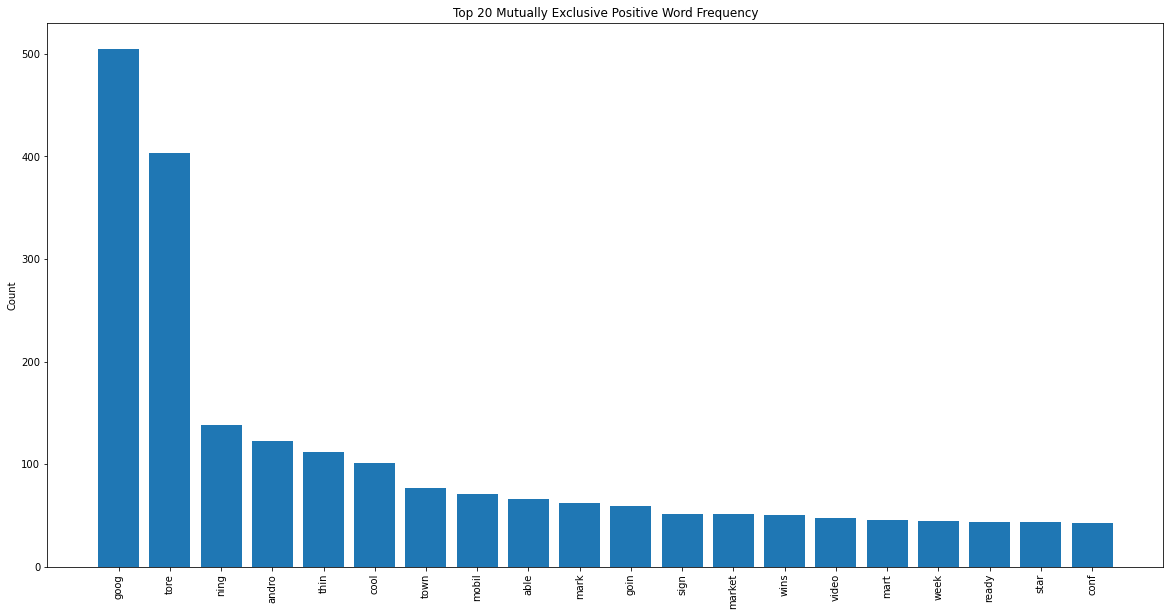

In [93]:
# View top 20 mutually exclusive positive words
positives_freq_dist = FreqDist(counts(diff_pos, positive['lemmed_text']))

visualize_top_20(positives_freq_dist, "Top 20 Mutually Exclusive Positive Word Frequency")

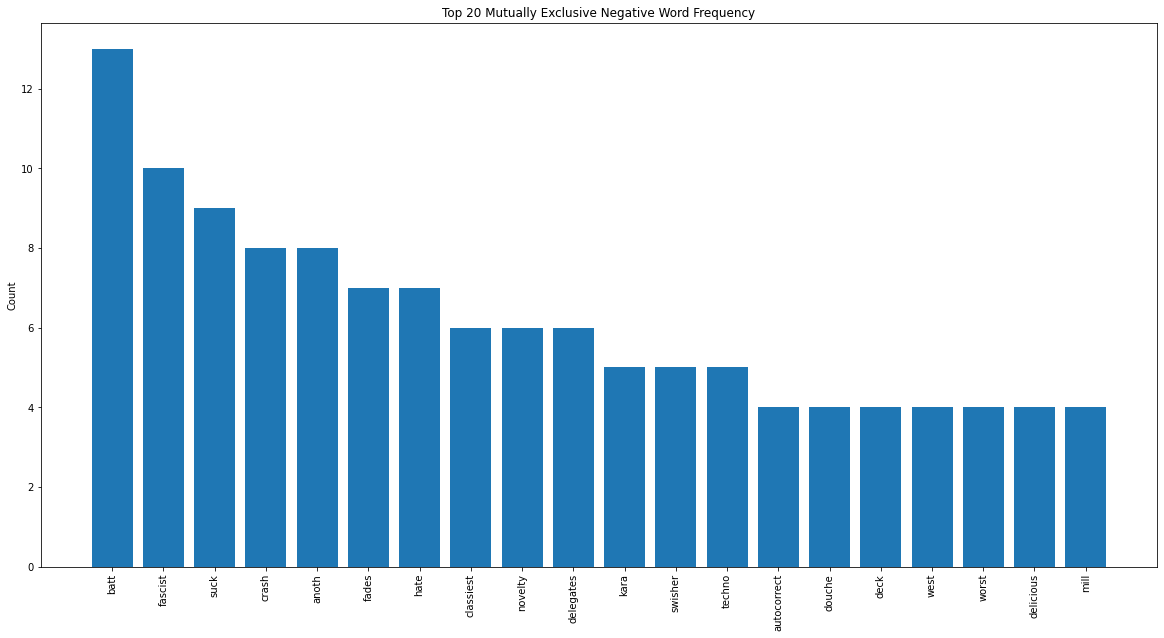

In [94]:
# # View top 20 mutually exclusive neggative words
negatives_freq_dist = FreqDist(counts(diff_neg, negative['lemmed_text']))

visualize_top_20(negatives_freq_dist, "Top 20 Mutually Exclusive Negative Word Frequency")

In [95]:
# Create a function to remove the mutual words and apply it to the training data
def remove_samewords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are in both pos and neg have been removed
    """
    same_rmv_list = [token for token in token_list if token not in sames]
    return same_rmv_list

pos_neg_train['sames_removed'] = pos_neg_train['lemmed_text_tokenized'].apply(remove_samewords)

In [96]:
pos_neg_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2731 entries, 1435 to 4378
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   text                   2731 non-null   object
 1   text_tokenized         2731 non-null   object
 2   stopwords_removed      2731 non-null   object
 3   regex_text             2731 non-null   object
 4   regex_text_tokenized   2731 non-null   object
 5   stemmed_text           2731 non-null   object
 6   lemmed_text            2731 non-null   object
 7   lemmed_text_tokenized  2731 non-null   object
 8   target                 2731 non-null   int64 
 9   sames_removed          2731 non-null   object
dtypes: int64(1), object(9)
memory usage: 299.2+ KB


In [97]:
# Join the tokenized mutually exclusive word column for modeling
pos_neg_train['sames'] = [' '.join(text) for text in pos_neg_train.sames_removed]

In [98]:
# Split the dataset back into Training and testing data
# The only thing that should change is the X_train set
X_train_diff = pos_neg_train.drop(['target'], axis=1)
y_train_diff = y_train
X_test_diff = X_test
y_test_diff = y_test

### Create a baseline model for the mutually exclusive data

In [99]:
# Vectorize our new training data
count_diff = CountVectorizer()
X_train_diff_vectorized = count_diff.fit_transform(X_train_diff['sames'])

In [100]:
# Balance the data
smote_diff = SMOTE(k_neighbors=3)
X_train_diff_resampled, y_train_diff_resampled = smote_diff.fit_resample(
    X_train_diff_vectorized, y_train_diff)

In [101]:
# Build the model
baseline_model_diff = MultinomialNB()

baseline_model_diff.fit(X_train_diff_resampled, y_train_diff_resampled)

# Evaluate the model
baseline_diff_cv = cross_val_score(baseline_model_diff, X_train_diff_resampled, y_train_diff_resampled)
print("Baseline_diff:", baseline_diff_cv.mean())

Baseline_diff: 0.6667012923528153


              precision    recall  f1-score   support

           0       0.34      0.65      0.45       121
           1       0.91      0.73      0.81       562

    accuracy                           0.71       683
   macro avg       0.62      0.69      0.63       683
weighted avg       0.81      0.71      0.74       683



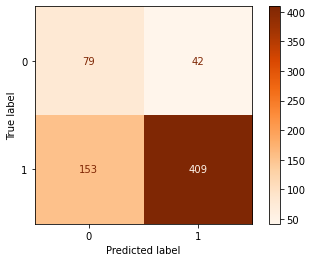

In [102]:
# Test the model
X_test_diff_vectorized = count_diff.transform(X_test_diff['lemmed_text'])
X_test_diff_preds = baseline_model_diff.predict(X_test_diff_vectorized)

print(classification_report(y_test_diff, X_test_diff_preds))

plot_confusion_matrix(baseline_model_diff, X_test_diff_vectorized, y_test_diff, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

### And a bigram one too

In [103]:
count_diff_bigram = CountVectorizer(ngram_range=(1,2))
X_train_diff_bigram_vectorized = count_diff_bigram.fit_transform(X_train_diff['sames'])

In [104]:
smote_diff_bigram = SMOTE(k_neighbors=3)
X_train_diff_resampled_bigram, y_train_diff_resampled_bigram = smote_diff_bigram.fit_resample(
    X_train_diff_bigram_vectorized, y_train_diff)

In [107]:
baseline_model_diff_bigram = MultinomialNB()
baseline_model_diff_bigram.fit(X_train_diff_resampled_bigram, y_train_diff_resampled_bigram)

baseline_diff_bigram_cv = cross_val_score(baseline_model_diff_bigram, X_train_diff_resampled_bigram, y_train_diff_resampled_bigram)
print("Baseline_diff        :", baseline_diff_cv.mean())
print("Baseline_diff_bigram :", baseline_diff_bigram_cv.mean())

Baseline_diff        : 0.6667012923528153
Baseline_diff_bigram : 0.6196706016173799


              precision    recall  f1-score   support

           0       0.36      0.58      0.44       121
           1       0.90      0.78      0.83       562

    accuracy                           0.74       683
   macro avg       0.63      0.68      0.64       683
weighted avg       0.80      0.74      0.76       683



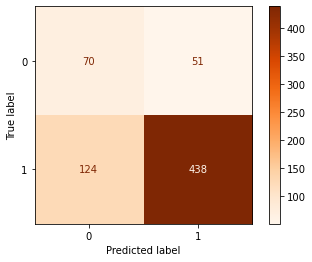

In [108]:
X_test_diff_bigram_vectorized = count_diff_bigram.transform(X_test_diff['lemmed_text'])
X_test_diff_bigram_preds = baseline_model_diff_bigram.predict(X_test_diff_bigram_vectorized)

print(classification_report(y_test_diff, X_test_diff_bigram_preds))

plot_confusion_matrix(baseline_model_diff_bigram, X_test_diff_bigram_vectorized, y_test_diff, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

### Build a few more models with the mutually exclusive data and see how they score

In [110]:
# Support Vector Machine
clf_diff = SVC()
clf_diff.fit(X_train_diff_resampled, y_train_diff_resampled)
clf_diff_cv = cross_val_score(clf_diff, X_train_diff_resampled, y_train_diff_resampled)
print("Baseline_diff        :", baseline_diff_cv.mean())
print("Baseline_diff_bigram :", baseline_diff_bigram_cv.mean())
print("SVM_diff             :", clf_diff_cv.mean())

Baseline_diff        : 0.6667012923528153
Baseline_diff_bigram : 0.6196706016173799
SVM                  : 0.8851427604505726


              precision    recall  f1-score   support

           0       0.32      0.44      0.37       121
           1       0.87      0.80      0.83       562

    accuracy                           0.74       683
   macro avg       0.60      0.62      0.60       683
weighted avg       0.77      0.74      0.75       683



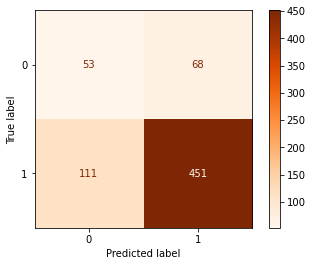

In [111]:
X_test_diff_preds_SVM = clf_diff.predict(X_test_diff_vectorized)

print(classification_report(y_test_diff, X_test_diff_preds_SVM))

plot_confusion_matrix(clf_diff, X_test_diff_vectorized, y_test_diff, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [112]:
# K Nearest Neighbors (n=5)
knn_5_diff = KNeighborsClassifier(n_neighbors=5)
knn_5_diff.fit(X_train_diff_resampled, y_train_diff_resampled)

knn_5_diff_cv = cross_val_score(knn_5_diff, X_train_diff_resampled, y_train_diff_resampled)
print("Baseline_diff        :", baseline_diff_cv.mean())
print("Baseline_diff_bigram :", baseline_diff_bigram_cv.mean())
print("SVM_diff             :", clf_diff_cv.mean())
print("KNN_5_diff           :", knn_5_diff_cv.mean())

Baseline_diff        : 0.6667012923528153
Baseline_diff_bigram : 0.6196706016173799
SVM_diff             : 0.8851427604505726
KNN_5_diff           : 0.612049033731842


              precision    recall  f1-score   support

           0       0.21      0.91      0.34       121
           1       0.93      0.27      0.42       562

    accuracy                           0.39       683
   macro avg       0.57      0.59      0.38       683
weighted avg       0.81      0.39      0.41       683



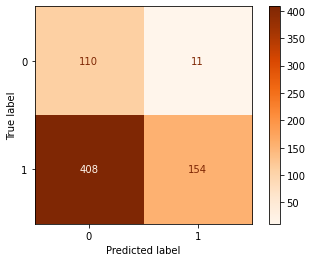

In [113]:
knn_5_diff_preds = knn_5_diff.predict(X_test_diff_vectorized)

print(classification_report(y_test_diff, knn_5_diff_preds))

plot_confusion_matrix(knn_5_diff, X_test_diff_vectorized, y_test_diff, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [114]:
# K Nearest Neighbors (n=3)
knn_3_diff = KNeighborsClassifier(n_neighbors=3)
knn_3_diff.fit(X_train_diff_resampled, y_train_diff_resampled)

knn_3_diff_cv = cross_val_score(knn_3_diff, X_train_diff_resampled, y_train_diff_resampled)
print("Baseline_diff        :", baseline_diff_cv.mean())
print("Baseline_diff_bigram :", baseline_diff_bigram_cv.mean())
print("SVM_diff             :", clf_diff_cv.mean())
print("KNN_5_diff           :", knn_5_diff_cv.mean())
print("KNN_3_diff           :", knn_3_diff_cv.mean())

Baseline_diff        : 0.6667012923528153
Baseline_diff_bigram : 0.6196706016173799
SVM_diff             : 0.8851427604505726
KNN_5_diff           : 0.612049033731842
KNN_3_diff           : 0.563498259706747


              precision    recall  f1-score   support

           0       0.94      0.13      0.23       121
           1       0.84      1.00      0.91       562

    accuracy                           0.84       683
   macro avg       0.89      0.57      0.57       683
weighted avg       0.86      0.84      0.79       683



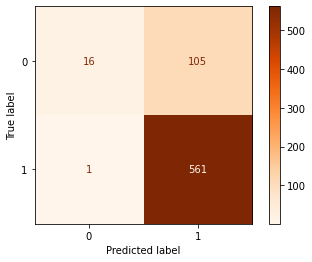

In [115]:
knn_3_diff_preds = knn_3_diff.predict(X_test_diff_vectorized)

print(classification_report(y_test_diff, knn_3_diff_preds))

plot_confusion_matrix(knn_3_diff, X_test_diff_vectorized, y_test_diff, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

### Very odd, KNN_3 positive accuracy was just about 100%, but only 13% on the negative class.      
### This is the opposite of what it was doing on the KKN_5 just above it, and on the lemmatized text 
>### Predicted mostly negative

In [116]:
tree_diff = DecisionTreeClassifier()

tree_diff.fit(X_train_diff_resampled, y_train_diff_resampled)

tree_diff_cv = cross_val_score(tree_diff, X_train_diff_resampled, y_train_diff_resampled)
print("Baseline_diff        :", baseline_diff_cv.mean())
print("Baseline_diff_bigram :", baseline_diff_bigram_cv.mean())
print("SVM_diff             :", clf_diff_cv.mean())
print("KNN_5_diff           :", knn_5_diff_cv.mean())
print("KNN_3_diff           :", knn_3_diff_cv.mean())
print("Tree_diff            :", tree_diff_cv.mean())

Baseline_diff        : 0.6667012923528153
Baseline_diff_bigram : 0.6196706016173799
SVM_diff             : 0.8851427604505726
KNN_5_diff           : 0.612049033731842
KNN_3_diff           : 0.563498259706747
Tree_diff            : 0.8188134983772148


              precision    recall  f1-score   support

           0       0.30      0.67      0.41       121
           1       0.90      0.66      0.76       562

    accuracy                           0.66       683
   macro avg       0.60      0.66      0.59       683
weighted avg       0.79      0.66      0.70       683



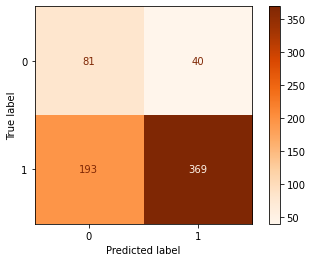

In [117]:
tree_diff_preds = tree_diff.predict(X_test_diff_vectorized)

print(classification_report(y_test_diff, tree_diff_preds))

plot_confusion_matrix(tree_diff, X_test_diff_vectorized, y_test_diff, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [118]:
# Random Forest (default)
forest_diff = RandomForestClassifier()

forest_diff.fit(X_train_diff_resampled, y_train_diff_resampled)

forest_diff_cv = cross_val_score(forest_diff, X_train_diff_resampled, y_train_diff_resampled)
print("Baseline_diff        :", baseline_diff_cv.mean())
print("Baseline_diff_bigram :", baseline_diff_bigram_cv.mean())
print("SVM_diff             :", clf_diff_cv.mean())
print("KNN_5_diff           :", knn_5_diff_cv.mean())
print("KNN_3_diff           :", knn_3_diff_cv.mean())
print("Tree_diff            :", tree_diff_cv.mean())
print("Forest_diff          :", forest_diff_cv.mean())


Baseline_diff        : 0.6667012923528153
Baseline_diff_bigram : 0.6196706016173799
SVM_diff             : 0.8851427604505726
KNN_5_diff           : 0.612049033731842
KNN_3_diff           : 0.563498259706747
Tree_diff            : 0.8188134983772148
Forest_diff          : 0.8159961269368253


              precision    recall  f1-score   support

           0       0.30      0.67      0.42       121
           1       0.90      0.67      0.77       562

    accuracy                           0.67       683
   macro avg       0.60      0.67      0.59       683
weighted avg       0.80      0.67      0.70       683



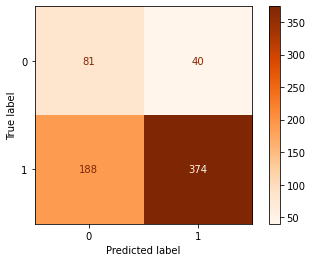

In [119]:
forest_diff_preds = forest_diff.predict(X_test_diff_vectorized)

print(classification_report(y_test_diff, forest_diff_preds))

plot_confusion_matrix(forest_diff, X_test_diff_vectorized, y_test_diff, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [124]:
# Random Forest (bootstrap=False)
forest_boot_diff = RandomForestClassifier(bootstrap=False)

forest_boot_diff.fit(X_train_diff_resampled, y_train_diff_resampled)

forest_boot_diff_cv = cross_val_score(forest_boot_diff, X_train_diff_resampled, y_train_diff_resampled)
print("Baseline_diff        :", baseline_diff_cv.mean())
print("Baseline_diff_bigram :", baseline_diff_bigram_cv.mean())
print("SVM_diff             :", clf_diff_cv.mean())
print("KNN_5_diff           :", knn_5_diff_cv.mean())
print("KNN_3_diff           :", knn_3_diff_cv.mean())
print("Tree_diff            :", tree_diff_cv.mean())
print("Forest_diff          :", forest_diff_cv.mean())
print("Forest_diff_boot     :", forest_boot_diff_cv.mean())


Baseline_diff        : 0.6667012923528153
Baseline_diff_bigram : 0.6196706016173799
SVM_diff             : 0.8851427604505726
KNN_5_diff           : 0.612049033731842
KNN_3_diff           : 0.563498259706747
Tree_diff            : 0.8188134983772148
Forest_diff          : 0.8159961269368253
Forest_diff_boot     : 0.825965504356021


              precision    recall  f1-score   support

           0       0.32      0.65      0.43       121
           1       0.90      0.70      0.79       562

    accuracy                           0.69       683
   macro avg       0.61      0.67      0.61       683
weighted avg       0.80      0.69      0.72       683



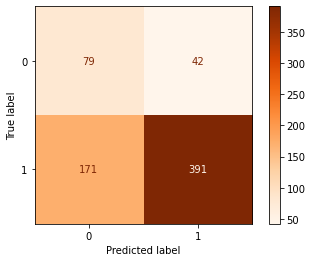

In [125]:
forest_boot_diff_preds = forest_boot_diff.predict(X_test_diff_vectorized)

print(classification_report(y_test_diff, forest_boot_diff_preds))

plot_confusion_matrix(forest_boot_diff, X_test_diff_vectorized, y_test_diff, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [ ]:
tfidf_diff = TfidfVectorizer(max_features=60)

X_train_diff_tdidf_vectorized = tfidf_diff.fit_transform(X_train_diff['sames'])

In [ ]:
smote_diff_tdidf = SMOTE(k_neighbors=3)
X_train_diff_resampled_tdidf, y_train_diff_resampled_tdidf = smote_diff_tdidf.fit_resample(
    X_train_diff_tdidf_vectorized, y_train_diff)

In [ ]:
baseline_model_diff_tdidf = MultinomialNB()

baseline_model_diff_tdidf.fit(X_train_diff_resampled_tdidf, y_train_diff_resampled_tdidf)

# Evaluate the model
baseline_diff_tdidf_cv = cross_val_score(baseline_model_diff_tdidf, X_train_diff_resampled_tdidf, y_train_diff_resampled_tdidf)
print("Baseline_diff_tdidf:", baseline_diff_tdidf_cv.mean())

In [ ]:
X_test_diff_tdidf_vectorized = tfidf_diff.transform(X_test_diff['lemmed_text'])
X_test_diff_tdidf_preds = baseline_model_diff_tdidf.predict(X_test_diff_tdidf_vectorized)

print(classification_report(y_test_diff, X_test_diff_tdidf_preds))